In [1]:
import requests
from bs4 import BeautifulSoup
import json
from datetime import datetime
# import UCSD_pdf_dates
import os
# import PyPDF2
# Base URL for the UCSD newspaper archives
base_url = "https://library.ucsd.edu/dc/"

# Load the subpage links from the ucsd_subpage_links.json file
with open("ucsd_subpage_links.json", "r") as f:
    subpage_links = json.load(f)

In [2]:
def get_article_links_and_dates(subpage_links):
    if os.path.exists('ucsd_article_pages.json'):
        # Open the JSON file for reading
        with open('ucsd_article_pages.json', 'r') as f:
            article_links = json.load(f)
    else:
        article_links = {}
    # Loop through all the subpages and scrape the PDF links
    for subpage_link in subpage_links:
        # Make a GET request to the subpage URL
        response = requests.get(subpage_link)

        # Create a BeautifulSoup object from the response HTML
        soup = BeautifulSoup(response.content, 'html.parser')

        # Find all the PDF links on the page
        articles = soup.find_all('li', class_='dams-sr') #pdf_links_on_page = soup.find_all('li', class_='dams-sr') 

        # Loop through all the PDF links and extract the PDF URL
        for article in articles:
            try:
                # Extract the relative URL for the PDF
                pdf_link_for_article = article.find('a', class_="dams-search-thumbnail-link")
                pdf_url = pdf_link_for_article['href']

                pdf_url = pdf_url.replace("/dc/", "")

                # Construct the absolute URL for the PDF file and add the "_1.pdf" suffix
                pdf_full_url = f"{base_url}{pdf_url.split('?')[0]}/_1.pdf"
                
                spans = article.find_all('span')

                date_elem = spans[4].text
                # Check if the date element exists and formats the dates (YYYY_mm_dd)
                if date_elem is not None:
                    date_obj = datetime.strptime(date_elem, '%B %d, %Y')
                    formatted_date = date_obj.strftime('%Y_%m_%d')
                    if(formatted_date.startswith("2008")):
                        break
                else:
                    raise ValueError("Could not find date element")

            except (KeyError, ValueError, AttributeError) as e:
                # Handle any exceptions that occur
                print(f"Error: {e}")
                continue
                
            article_links[formatted_date] = [pdf_full_url]
        continue
    with open("uf_article_pages.json", "w") as outfile:
        json.dump(article_links, outfile, indent=4)

    return article_links

In [3]:
article_pages = get_article_links_and_dates(subpage_links)

Error: time data 'November, 12, 2019' does not match format '%B %d, %Y'
Error: time data 'November, 4, 2019' does not match format '%B %d, %Y'


In [4]:
print(f"There are {len(article_pages)} dates with articles")
total_size = sum([len(article_pages[key]) for key in article_pages])
print(f"There are {total_size} articles to iterate over")

There are 649 dates with articles
There are 649 articles to iterate over


In [5]:
from helpers.pdf_to_text import extract_pdf_text
from helpers.make_txt_entry import make_txt_entry
import os

school_name = "UCSD"
for date, articles in article_pages.items():
    file_path = "journal_data/txt/"+school_name.replace(" ","_")+"/"+date+".txt"
    if(os.path.exists(file_path)):
        print(f"Date {date} already added.")
    else:
        article_text = extract_pdf_text(articles[0])
            
        make_txt_entry(school_name=school_name, publication_date=date, text=article_text)
        print(f"Date {date} added.")

Date 2023_01_30 added.
Date 2023_01_23 added.
Date 2023_01_17 added.
Date 2023_01_09 added.
Date 2022_12_23 added.
Date 2022_12_04 added.
Date 2022_11_29 added.
Date 2022_11_28 added.
Date 2022_11_21 added.
Date 2022_11_14 added.
Date 2022_11_07 added.
Date 2022_10_31 added.
Date 2022_10_17 added.
Date 2022_10_10 added.
Date 2022_10_03 added.
Date 2022_09_26 added.
Date 2022_08_11 added.
Date 2022_08_04 added.
Date 2022_07_18 added.
Date 2022_06_20 added.
Date 2022_05_31 added.
Date 2022_05_23 added.
Date 2022_05_16 added.
Date 2022_05_09 added.
Date 2022_05_02 added.
Date 2022_04_18 added.
Date 2022_04_11 added.
Date 2022_04_04 added.
Date 2022_04_25 added.
Date 2022_03_28 added.
Date 2022_03_07 added.
Date 2022_02_28 added.
Date 2022_02_22 added.
Date 2022_02_14 added.
Date 2022_02_07 added.
Date 2022_01_31 added.
Date 2022_01_24 added.
Date 2022_01_18 added.
Date 2022_01_10 added.
Date 2022_01_03 added.
Date 2021_11_29 added.
Date 2021_11_22 added.
Date 2021_11_15 added.
Date 2021_1

KeyboardInterrupt: 

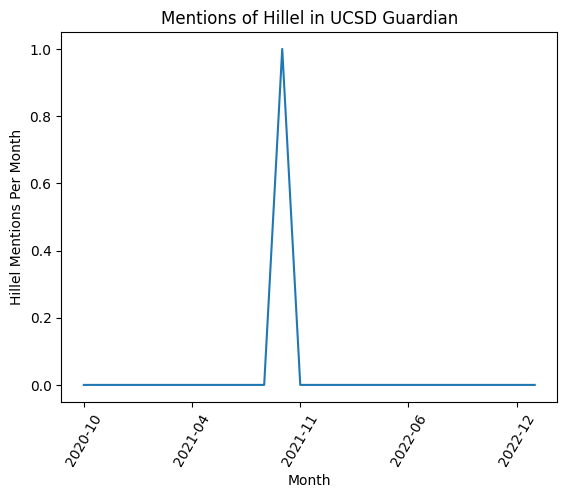

In [8]:
from helpers.graphers import monthly_grapher
from helpers.queries import hillel_counter

school_name = "UCSD"
newspaper_name = "UCSD Guardian"
school_name_lower = school_name.lower()

UMich_pipeline = []

directory = 'journal_data/txt/' + school_name

monthly_grapher(directory=directory,
                pipeline=UMich_pipeline,
                query=hillel_counter,
                y_label="Hillel Mentions Per Month",
                title="Mentions of Hillel in " + newspaper_name,
                save_path='figures/' + school_name + '/' + school_name + '_hillel_mentions.png')

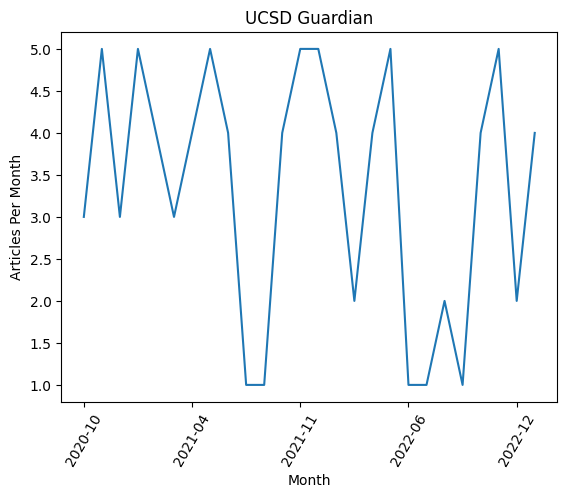

In [6]:
from helpers.queries import one_query
from helpers.graphers import monthly_grapher

school_name = "UCSD"
newspaper_name = "UCSD Guardian"
school_name_lower = school_name.lower()

directory = 'journal_data/txt/' + school_name

monthly_grapher(directory=directory,
                pipeline=[],
                query=one_query,
                y_label="Articles Per Month",
                title=newspaper_name,
                save_path='figures/' + school_name + '/' + school_name + '_monthly_articles.png')
